In [1]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import itertools
from sklearn.impute import KNNImputer
import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import FunctionTransformer
from fitter import Fitter, get_common_distributions, get_distributions
import time
from datetime import datetime

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_4rxr0p4 because the default path (/home/bold_satoshi/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/bold_satoshi/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv('../DATA/train_airbnb_berlin.xls')

# Pre processing

### Feature analysis

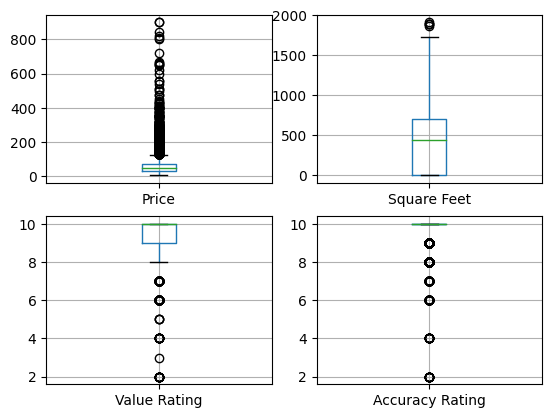

In [60]:
plt.subplot(221)
df_train.boxplot(column='Price')

plt.subplot(222)
df_train.boxplot(column='Square Feet')

plt.subplot(223)
df_train.boxplot(column='Value Rating')

plt.subplot(224)
df_train.boxplot(column='Accuracy Rating')

plt.show()

In [61]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [62]:
nan_percentage = percentage_of_nans(df_train)
df = nan_percentage[nan_percentage['Percentage of NaNs'] >= 18]
df.sort_values(by=['Percentage of NaNs'], ascending=False).reset_index().drop(['index'], axis=1)

,Feature Name,Percentage of NaNs
0,Square Feet,98.06
1,Host Response Time,45.08
2,Host Response Rate,45.08
3,Checkin Rating,18.94
4,Accuracy Rating,18.93
5,Location Rating,18.93
6,Value Rating,18.93
7,Cleanliness Rating,18.92
8,Communication Rating,18.92
9,Overall Rating,18.87


### Data cleaning

In [3]:
from sklearn.preprocessing import LabelEncoder

def pre_process_raw(df: pd.DataFrame):
    df.columns = df.columns. str.lower().str.replace(' ','_')         

    # Converting to datetime
    df.host_since = pd.to_datetime(df.host_since)               

    cols_to_drop = ['listing_name', 'host_id', 'host_name', 'city', 'country_code', 'country' ]
    df = df.drop(cols_to_drop, axis=1)
    df.set_index('listing_id', inplace=True)

    df.drop(['square_feet'], axis=1, inplace=True)

    for col in df.columns:
        df[col] = df[col].replace('*', np.nan)

    df.drop(['first_review','last_review'], axis=1, inplace=True)
    df = df.dropna(subset=['price'], how='all')
    df = df.dropna(subset=['overall_rating', 'accuracy_rating','cleanliness_rating','checkin_rating',
                            'communication_rating','location_rating','value_rating'], how='all')
    
    change = ['postal_code','accomodates','latitude',
          'longitude','bathrooms','bedrooms','beds','guests_included','min_nights','reviews','overall_rating','accuracy_rating',
          'cleanliness_rating','checkin_rating', 'communication_rating','location_rating','value_rating' ]

    for i in change:
        df[i]=pd.to_numeric(df[i], downcast="float")

    #Replacing the null values


    obj = df.select_dtypes(include = "object").columns
    le = LabelEncoder()
    for i in obj:
        df[i] = le.fit_transform(df[i].astype(str))
    
    X = df.drop('price', axis = 1)

    # Output/Dependent variable

    y = df['price']
    return X, y

def median_imputer(df: pd.DataFrame):
    change = ['postal_code','accomodates','latitude',
        'longitude','bathrooms','bedrooms','beds','guests_included','min_nights','reviews','overall_rating','accuracy_rating',
        'cleanliness_rating','checkin_rating', 'communication_rating','location_rating','value_rating' ]

    print(df.columns)
    
    df = df.copy()

    # Calculating the number of days    
    df['host_days_active'] = (datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]').copy()

    # Replacing null values with the median
    df['host_days_active'] = df.host_days_active.fillna(df.host_days_active.median()).copy()

    df['host_days_active'] = (datetime(2019, 7, 21) - df.host_since).astype('timedelta64[D]').copy()
    df = df.drop('host_since', axis=1).copy()

    for col in change:
        df[col].fillna(df[col].median(), inplace=True)

    df = df.fillna(0).copy()

    return df

In [4]:
def fit_clf_scaler_cv(clf, X, y, clf_params, n_features=26):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    
    metric = []
    X = median_imputer(X)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_features)),
        ('svr', clf(**clf_params))])
        
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test)**(1/2)
        metric.append(rmse)
    return np.array(metric).mean()

def fit_clf_scaler(clf, X, y, clf_params, n_features=26):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([('median_imputer', FunctionTransformer(median_imputer)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))], verbose=1)
    
    pipe.fit(X,y)
    return pipe 

In [5]:
X, y = pre_process_raw(df_train)

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### Train test split

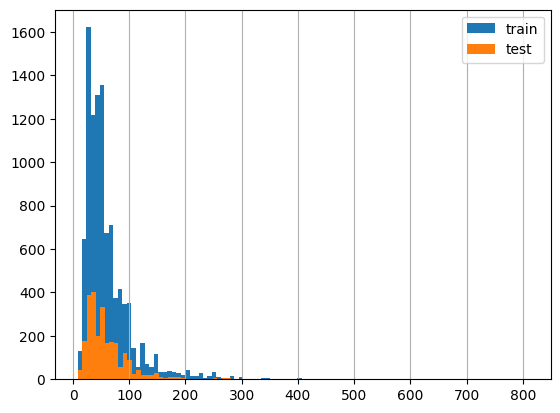

In [7]:
plt.hist(y_train,bins=100, label='train')
plt.hist(y_test, bins=100,label='test')
plt.legend()
plt.grid(axis='x')
plt.show()


Fitting 5 distributions: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,0.000074,1981.694736,-241262.345112,inf,0.045383,3.221602e-23
beta,0.000145,3168.370031,-232761.691453,inf,0.095318,4.235137e-101
norm,0.000480,8769.505263,-217554.043109,inf,0.179096,0.000000e+00
gamma,0.001484,25858.296772,-203167.414114,inf,0.993223,0.000000e+00
lognorm,0.001603,1793.180180,-202187.780540,inf,0.671548,0.000000e+00


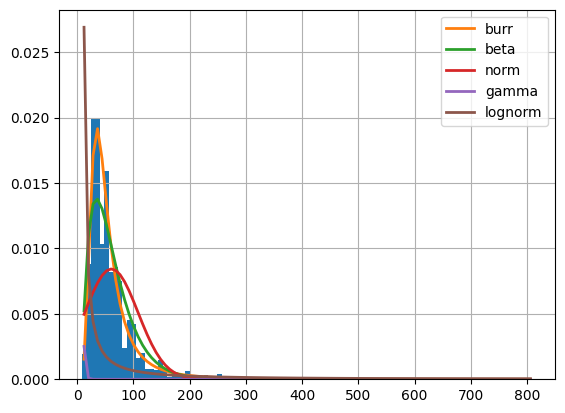

In [8]:
f = Fitter(y.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [12]:
f_train = Fitter(y_train.values, distributions=['burr'])
f_train.fit()

display(f_train.get_best())

f_test = Fitter(y_test.values, distributions=['burr'])
f_test.fit()
display(f_test.get_best())


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


{'burr': {'c': 2.4336757321267513,
  'd': 2.3736987014670436,
  'loc': -0.1117503663963326,
  'scale': 30.190820465770095}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


{'burr': {'c': 2.350771491630069,
  'd': 2.6101279071387133,
  'loc': -0.09477798726861912,
  'scale': 28.50946706833561}}

In [13]:
from scipy.special import rel_entr
from scipy.stats import burr

r_train = burr.rvs(**(f_train.get_best()['burr']),size=1000)
r_test = burr.rvs(**(f_test.get_best()['burr']),size=1000)
r_test_base = burr.rvs(**(f_test.get_best()['burr']),size=1000)
print('KL divergence between train and test: ', sum(rel_entr(r_train, r_test)))
print('KL divergence reference: ', sum(rel_entr(r_test, r_test_base)))

KL divergence between train and test:  26194.48171235727
KL divergence reference:  27599.514757022785


# Feature analysis

### PCA

Index(['host_since', 'host_response_time', 'host_response_rate',
       'is_superhost', 'neighbourhood', 'neighborhood_group', 'postal_code',
       'latitude', 'longitude', 'is_exact_location', 'property_type',
       'room_type', 'accomodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'min_nights', 'reviews', 'overall_rating',
       'accuracy_rating', 'cleanliness_rating', 'checkin_rating',
       'communication_rating', 'location_rating', 'value_rating',
       'instant_bookable', 'business_travel_ready'],
      dtype='object')


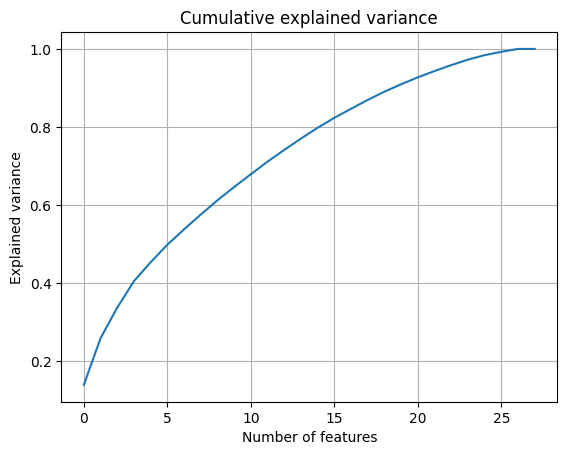

Explained variance with 24 features:  0.9926008696684153


In [9]:
pipe = Pipeline([('median_imputer', FunctionTransformer(median_imputer)),
('scaler', StandardScaler()),
('pca', PCA())])

pipe.fit(X_train)
explained_variance = pipe['pca'].explained_variance_ratio_
acc_sum = np.cumsum(explained_variance) 

plt.title('Cumulative explained variance')
plt.plot(acc_sum)
plt.grid()
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()

print('Explained variance with 24 features: ', acc_sum[25])

### Forward selection + Cross Validation

In [10]:
def get_feature_importance(clf, params):
	r2 = [] 
	features = []
	n_features = []

	for k in range(1,len(X.columns) + 1):
		r2_tmp = []
		for new_feat in X_train.columns:
			if new_feat in features: continue
			new_features = features.copy()
			new_features.append(new_feat)
			r2_val = fit_clf_scaler(clf, X_train[new_features],y_train, params)   
			r2_tmp.append((r2_val, new_feat))                 
		r2.append(sorted(r2_tmp, key=lambda x: x[0])[-1][0])	
		new_feat = sorted(r2_tmp, key=lambda x: x[0])[-1][1]
		features.append(new_feat)
		n_features.append(len(features))   

	df = pd.DataFrame({'n_features': n_features,'R2': r2,'features':features})

	return df

In [91]:
df = get_feature_importance(linear_model.LinearRegression, {})
plt.title('Cross-validated subset selection - Linear Regression')
plt.xlabel('Number of features')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['n_features'], df['R2'])
plt.show()


Index(['host_response_time'], dtype='object')


AttributeError: 'DataFrame' object has no attribute 'host_since'

### Autoencoder

In [114]:

n_input = X_train.columns

n_encoder1 = 50
n_encoder2 = 30

n_latent = 2

n_decoder2 = 30
n_decoder1 = 50

In [115]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 1e-4, 
                   max_iter = 100, 
                   tol = 0.0000001, 
                   verbose = False)

In [116]:
reg.fit(X_train, y_train)

/home/josemelocosta/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 30, 2, 30, 50),
             learning_rate_init=0.0001, max_iter=100, tol=1e-07)

In [117]:
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

test_latent = encoder(X_train)


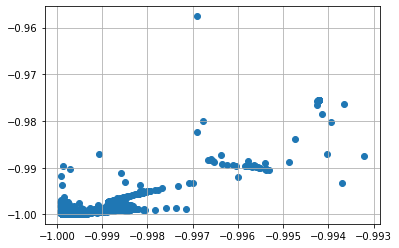

In [120]:
plt.scatter(test_latent[:, 0], test_latent[:, 1])
plt.grid()
plt.show()

# Model selection

In [11]:
from sklearn.metrics import mean_squared_error

### Decision Trees

#### Optimization

Index(['host_since', 'host_response_time', 'host_response_rate',
       'is_superhost', 'neighbourhood', 'neighborhood_group', 'postal_code',
       'latitude', 'longitude', 'is_exact_location', 'property_type',
       'room_type', 'accomodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'min_nights', 'reviews', 'overall_rating',
       'accuracy_rating', 'cleanliness_rating', 'checkin_rating',
       'communication_rating', 'location_rating', 'value_rating',
       'instant_bookable', 'business_travel_ready'],
      dtype='object')
Index(['host_since', 'host_response_time', 'host_response_rate',
       'is_superhost', 'neighbourhood', 'neighborhood_group', 'postal_code',
       'latitude', 'longitude', 'is_exact_location', 'property_type',
       'room_type', 'accomodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'min_nights', 'reviews', 'overall_rating',
       'accuracy_rating', 'cleanliness_rating', 'checkin_rating',
       'communication_rating'

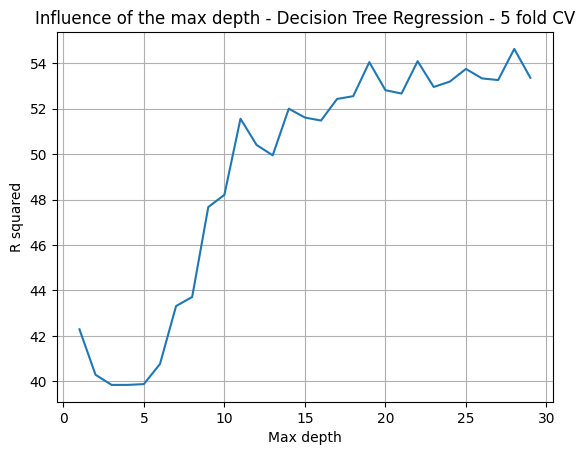

In [13]:
r2 = []
max_depth = []
for k in range(1, 30):
    r2_val = fit_clf_scaler_cv(DecisionTreeRegressor, X_train,y_train, {"max_depth": k}) 
    r2.append(r2_val)	
    max_depth.append(k)

df = pd.DataFrame({'R2': r2,'max_depth':max_depth})
plt.title('Influence of the max depth - Decision Tree Regression - 5 fold CV')
plt.xlabel('Max depth')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['max_depth'], df['R2'])
plt.show()

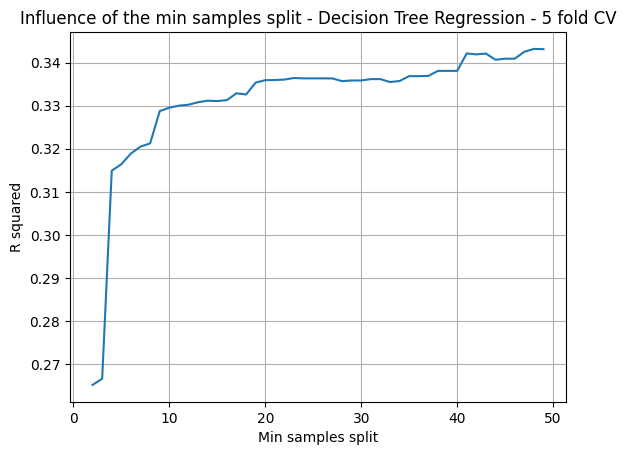

In [95]:
r2 = []
min_samples_split = []
for k in range(2, 50):
    r2_val = fit_clf(DecisionTreeRegressor, X_train[new_features],y_train, {"min_samples_split": k}) 
    r2.append(r2_val)	
    min_samples_split.append(k)

df = pd.DataFrame({'R2': r2,'min_samples_split':min_samples_split})
plt.title('Influence of the min samples split - Decision Tree Regression - 5 fold CV')
plt.xlabel('Min samples split')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['min_samples_split'], df['R2'])
plt.show()

In [97]:
parameters = {'max_depth':np.arange(1, 15), 'min_samples_split':np.arange(2, 5)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters)
clf.fit(X_train, y_train)
print('Best params: ', clf.best_params_)
print('Best score: ', clf.best_score_)

Best params:  {'max_depth': 4, 'min_samples_split': 2}
Best score:  0.3336581268285735


#### Model selection

In [24]:
clf_params = {'max_depth': 4, 'min_samples_split': 2}
imputer_params = {"n_neighbors": 3}
pipe = fit_clf_scaler(DecisionTreeRegressor, X_train, y_train, clf_params, imputer_params)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

[Pipeline] ....... (step 1 of 5) Processing pre_process, total=   0.0s
[Pipeline] ........... (step 2 of 5) Processing imputer, total=  14.3s
[Pipeline] ............ (step 3 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 4 of 5) Processing pca, total=   0.2s
[Pipeline] ............... (step 5 of 5) Processing svr, total=   0.3s
r_squared:  0.36643237820876284
rmse:  38.31193351469978


### SVM

#### Optimization

In [ ]:

def objective(trial: optuna.trial.Trial):

    parameters = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-3, 1e3),
        'epsilon': trial.suggest_float('epsilon', 1e-3, 1)
    }

    clf = svm.SVR
    return -fit_clf_scaler(clf, X_train, y_train, parameters)

study = optuna.create_study()
study.optimize(objective, n_trials=1)


#### Model selection

In [370]:
clf_params = {'kernel': 'rbf', 'C': 595.6756199722245, 'epsilon': 0.8771538699650302}
imputer_params = {"n_neighbors": 3}
fit_clf_scaler(svm.SVR, X_train, y_train, clf_params, imputer_params, n_features=28)

[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=  47.2s


Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=28)),
                ('svr', SVR(C=595.6756199722245, epsilon=0.8771538699650302))],
         verbose=1)

In [372]:
pipe = fit_clf_scaler(svm.SVR, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)

[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=  47.6s


In [373]:
rmse = mean_squared_error(y_pred, y_test)**(1/2)

In [374]:
print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.31228753828216727
rmse:  35.45425248695693


### AdaBoost

#### Optimization

In [12]:

def objective(trial: optuna.trial.Trial):

    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1)
    }

    clf = AdaBoostRegressor
    return -fit_clf_scaler(clf, X_train, y_train, parameters, n_features=5)

study = optuna.create_study()
study.optimize(objective, n_trials=10)


[I 2022-10-25 20:13:25,943] A new study created in memory with name: no-name-fe4bc88d-2ebe-4483-a0cb-36e440b5cfd1
[I 2022-10-25 20:13:30,579] Trial 0 finished with value: 0.775794758150748 and parameters: {'n_estimators': 200, 'learning_rate': 0.3890851033130652}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:34,626] Trial 1 finished with value: 1.4470120718879524 and parameters: {'n_estimators': 107, 'learning_rate': 0.5049110671832184}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:39,200] Trial 2 finished with value: 1.0269724904664261 and parameters: {'n_estimators': 177, 'learning_rate': 0.4116827080077768}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:44,815] Trial 3 finished with value: 1.4601433789501144 and parameters: {'n_estimators': 174, 'learning_rate': 0.33538487460819755}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:49,333] Trial 4 finished with value: 0.7154979268822259 and parameters

#### Model selection

In [376]:
clf_params = {'n_estimators': 119, 'learning_rate': 0.9617041908836014}
imputer_params = {"n_neighbors": 3}
pipe = fit_clf_scaler(AdaBoostRegressor, X_train, y_train, clf_params, imputer_params, n_features=28)

[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=   2.1s


In [377]:
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)

In [378]:
print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  -1.1441387185777665
rmse:  35.45425248695693


### KNN

#### Optimization

In [386]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_clf_scaler_cv(clf, X, y, clf_params, imputer_params, n_features=43):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    
    metric = []
    imputer = KNNImputer(**imputer_params)
    imputed = imputer.fit_transform(X)
    X = pd.DataFrame(imputed, columns=X.columns)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_features)),
        ('svr', clf(**clf_params))])
        
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test)**(1/2)
        metric.append(rmse)
    return np.array(metric).mean()


def objective(trial: optuna.trial.Trial):

    trial_suggestion = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 200),
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),
    }

    clf_params = {
        'n_neighbors': trial_suggestion['n_neighbors'],
        'leaf_size': trial_suggestion['leaf_size'],
        'n_jobs': -1
    }
    imputer_params = {
        "n_neighbors": 3
    }

    clf = KNeighborsRegressor
    return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=28)

study = optuna.create_study()
study.optimize(objective, n_trials=30, n_jobs=-1)



[I 2022-10-27 01:37:03,160] A new study created in memory with name: no-name-c7ca8a52-e9db-4024-b790-be06983f4bda
[I 2022-10-27 01:37:06,247] Trial 1 finished with value: 37.269399946280224 and parameters: {'n_neighbors': 9, 'leaf_size': 30}. Best is trial 1 with value: 37.269399946280224.
[I 2022-10-27 01:37:06,285] Trial 0 finished with value: 38.44130324211633 and parameters: {'n_neighbors': 5, 'leaf_size': 34}. Best is trial 1 with value: 37.269399946280224.
[I 2022-10-27 01:37:06,578] Trial 7 finished with value: 48.80545560087855 and parameters: {'n_neighbors': 1, 'leaf_size': 18}. Best is trial 1 with value: 37.269399946280224.
[I 2022-10-27 01:37:06,970] Trial 6 finished with value: 36.55611760119297 and parameters: {'n_neighbors': 35, 'leaf_size': 44}. Best is trial 6 with value: 36.55611760119297.
[I 2022-10-27 01:37:07,477] Trial 4 finished with value: 36.94531607533883 and parameters: {'n_neighbors': 78, 'leaf_size': 41}. Best is trial 6 with value: 36.55611760119297.
[I 20

#### Model Selection

In [387]:
from sklearn.neighbors import KNeighborsRegressor

clf_params =  {'n_neighbors': 84, 'leaf_size': 26}
imputer_params = {
    "n_neighbors": 3
}
pipe = fit_clf_scaler(KNeighborsRegressor, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
print('r_squared: ', r_squared)
print('rmse: ', rmse)

[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=   0.0s
r_squared:  0.3991066217178917
rmse:  35.45425248695693


### Gradient Tree Boosting

#### Optimization

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial: optuna.trial.Trial):

    trial_suggestion = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'n_neighbors': trial.suggest_int('n_neighbors',  2, 4),
        'n_features': trial.suggest_int('n_features', 10, 54)
    }

    clf_params = {
        'n_estimators': trial_suggestion['n_estimators'],
        'learning_rate': trial_suggestion['learning_rate'],
        'max_depth': trial_suggestion['max_depth'],
    }
    imputer_params = {
        "n_neighbors": trial_suggestion['n_neighbors']
    }

    clf = GradientBoostingRegressor
    return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=trial_suggestion['n_features'])

study = optuna.create_study()
study.optimize(objective, n_trials=10, n_jobs=-1)



#### Model selection

In [364]:
clf_params = {'n_estimators': 178, 'learning_rate': 0.15253399946567545, 'max_depth': 2} 
imputer_params = {"n_neighbors": 3}
pipe = fit_clf_scaler(GradientBoostingRegressor, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=   9.9s
r_squared:  0.3878889868899279
rmse:  33.44875695528625


### MLP

In [ ]:
!pip install lazypredict

#### Optimization

In [21]:
simplefilter("ignore", category=ConvergenceWarning)


def fit_clf_scaler_cv(clf, X, y, clf_params, imputer_params, n_features=43):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_features)),
        ('svr', clf(**clf_params))])
        
        pipe.fit(X_train,y_train)
        y_pred = pipe.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test)**(1/2)
        metric.append(rmse)
    return np.array(metric).mean()

def objective(trial: optuna.trial.Trial):

    trial_suggestions = {
        'first_layer': trial.suggest_int('first_layer', 1, 100),
        'second_layer': trial.suggest_int('second_layer', 1, 100),
        'activation': trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'relu'])
    }

    clf = MLPRegressor 
    clf_params = {
        'hidden_layer_sizes': (trial_suggestions['first_layer'], trial_suggestions['second_layer']),#, trial_suggestions['third_layer']),
        'activation': trial_suggestions['activation'],
        'max_iter': 200,
        'learning_rate': 'adaptive'
    }
    imputer_params = {
        "n_neighbors": 3
    }
    return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, 28)

study = optuna.create_study()
study.optimize(objective, n_trials=20, n_jobs=-1)

[I 2022-10-27 02:09:30,716] A new study created in memory with name: no-name-9fdadcac-8165-4146-91d2-51401fde83c8


#### Model selection

[I 2022-10-27 01:55:31,546] Trial 0 finished with value: 32.689708727150084 and parameters: {'first_layer': 93, 'second_layer': 47, 'activation': 'logistic'}. Best is trial 0 with value: 32.689708727150084.


In [16]:
def fit_clf_scaler_pipe(clf, X, y, clf_params, imputer_params, n_features=43):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))])
    
    pipe.fit(X,y)
    return pipe
clf_params = {
    "hidden_layer_sizes": (93, 47),
    "activation": 'logistic'
}
imputer_params = {
    "n_neighbors": 3
}
model = sklearn.neural_network.MLPRegressor
pipe = fit_clf_scaler_pipe(model, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.4154780426799747
rmse:  32.68626528119727


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### XGBoost

#### Model selection

In [361]:
from xgboost import XGBRegressor
def fit_clf_scaler(clf, X, y, clf_params, imputer_params, n_features=37):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([
    ('imputer', KNNImputer(**imputer_params)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))], verbose=1)
    
    pipe.fit(X,y)
    return pipe 

clf_params = {
    "learning_rate": 0.001,
    "n_estimators":6000,
    "max_depth":4,
    "min_child_weight":0,
    "gamma":0.6,
    "subsample":0.7,
    "colsample_bytree":0.7,
    "objective":'reg:squarederror',
    "nthread":-1,
    "scale_pos_weight":1,
    "seed":27,
    "reg_alpha":0.00006,
    "random_state":42
}
imputer_params = {"n_neighbors": 3}
pipe = fit_clf_scaler(XGBRegressor, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_pred, y_test)**(1/2)

print('r_squared: ', r_squared)
print('rmse: ', rmse)


[Pipeline] ........... (step 1 of 4) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing pca, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing svr, total=  42.7s
r_squared:  0.3962699336625629
rmse:  33.218979643663836


### Random Forest

In [389]:
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial: optuna.trial.Trial):

    trial_suggestion = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'n_neighbors': trial.suggest_int('n_neighbors',  2, 4),
    }

    clf_params = {
        "n_estimators": trial_suggestion['n_estimators'],
        "criterion": "squared_error",

    }
    imputer_params = {
        "n_neighbors": trial_suggestion['n_neighbors']
    }

    clf = GradientBoostingRegressor
    return fit_clf_scaler_cv(clf, X_train, y_train, clf_params, imputer_params, n_features=28)

study = optuna.create_study()
study.optimize(objective, n_trials=10, n_jobs=-1)



[I 2022-10-27 01:39:15,323] A new study created in memory with name: no-name-1f95ccdf-b623-4866-854a-33bd7c0164cf
[I 2022-10-27 01:39:29,671] Trial 1 finished with value: 38.269789754838406 and parameters: {'n_estimators': 15, 'max_depth': 10, 'n_neighbors': 3}. Best is trial 1 with value: 38.269789754838406.
[I 2022-10-27 01:40:05,848] Trial 6 finished with value: 36.65043646930766 and parameters: {'n_estimators': 55, 'max_depth': 1, 'n_neighbors': 4}. Best is trial 6 with value: 36.65043646930766.
[I 2022-10-27 01:40:24,956] Trial 4 finished with value: 36.411537629955106 and parameters: {'n_estimators': 71, 'max_depth': 3, 'n_neighbors': 2}. Best is trial 4 with value: 36.411537629955106.
[I 2022-10-27 01:40:28,736] Trial 7 finished with value: 36.42361486957127 and parameters: {'n_estimators': 79, 'max_depth': 17, 'n_neighbors': 3}. Best is trial 4 with value: 36.411537629955106.
[I 2022-10-27 01:40:36,088] Trial 5 finished with value: 36.43113405099212 and parameters: {'n_estimato

In [18]:
from sklearn.ensemble import RandomForestRegressor
def fit_clf_scaler(clf, X, y, clf_params, imputer_params, n_features=37):
    X = X.copy()
    y = y.copy()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))], verbose=1)
    
    pipe.fit(X,y)
    return pipe 

clf_params = {'n_estimators': 134, 'max_depth': 5}
imputer_params = {
    "n_neighbors": 2
}
pipe = fit_clf_scaler(RandomForestRegressor, X_train, y_train, clf_params, imputer_params, n_features=28)
r_squared = pipe.score(X_test,y_test)
y_pred = pipe.predict(X_test)
print('r_squared: ', r_squared)
print('rmse: ', rmse)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svr, total=  10.0s
r_squared:  0.34239202211821196
rmse:  32.68626528119727


### MLP + XGBoost

In [300]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):

    def __init__(self, params):
        super(MLP, self).__init__()
        self.first_layer = nn.Linear(params['n_components'], params['first_layer'])
        self.second_layer = nn.Linear(params['first_layer'], params['latent_variables'])
        self.last_layer = nn.Linear(params['latent_variables'], 1)
        self.layers = nn.Sequential(
            self.first_layer,
            nn.ReLU(),
            self.second_layer,
            nn.ReLU(),
            self.last_layer
        )

    def forward(self, x):
        out = self.layers(x)
        return out

        
clf_params = {
    'n_components': 43,
    'first_layer': 30,
    'latent_variables': 10,
    'learning_rate': 1e-5
}

model = MLP(clf_params).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [301]:
X_train_mlp, X_train_xgb, y_train_mlp, y_train_xgb = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.1, random_state=10)

In [302]:
pipe = Pipeline([('pre_process', FunctionTransformer(process_model_1)),
('imputer', KNNImputer(**imputer_params)),
('scaler', StandardScaler()),
('pca', PCA(n_components=clf_params['n_components']))])

pipe.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 FunctionTransformer(func=<function process_model_1 at 0x7fd495ee5240>)),
                ('imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=43))])

In [298]:
X_train_piped_mlp = pipe.transform(X_train)
X_train_piped_xgb = pipe.transform(X_train_xgb)

AttributeError: This 'Pipeline' has no attribute 'transform'

In [280]:
X_test_piped = pipe.transform(X_test) 
X_test_xgboost = model.layers[:2](torch.Tensor(X_test_piped).to(device))
X_test_xgboost = X_test_xgboost.detach().cpu()

In [297]:
import torch.utils.data as data_utils

batch_size = 128
train_target = torch.tensor(y_train.values.astype(np.float32))
train = torch.tensor(X_train_piped_mlp.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
epochs = 10

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)

        output = model(x)
        #print('output: ', output, output.size())
        #print('y: ', y, y.size())
        loss = r2_loss(output, y)
        asdfsdaf
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

In [283]:
y_pred = model.layers(torch.Tensor(X_test_piped).to(device)).detach().cpu().numpy()
rmse = mean_squared_error(y_pred, y_test)**(1/2)
r_squared = r2_score(y_test, y_pred)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  0.006208638447626202
rmse:  47.98275629246058


In [221]:
X_train_xgboost = model.layers[:2](torch.Tensor(X_train_piped_xgb).to(device))
X_train_xgboost = X_train_xgboost.detach().cpu()

In [222]:
clf_params_xgb = {'max_depth':5, 'eta':1, 'objective':'reg:squarederror' }

xgb = XGBRegressor(**clf_params_xgb)

xgb.fit(X_train_xgboost, y_train_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [224]:
from sklearn.metrics import r2_score

In [225]:
y_pred = xgb.predict(X_test_xgboost)
rmse = mean_squared_error(y_pred, y_test)**(1/2)
r_squared = r2_score(y_test, y_pred)

print('r_squared: ', r_squared)
print('rmse: ', rmse)

r_squared:  -0.08663525234644198
rmse:  50.17408695252223
